In [2]:
!nvidia-smi

Thu Apr 23 14:04:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:01:00.0 Off |                  N/A |
| 37%   52C    P8    11W / 250W |   8825MiB / 12192MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import dnnlib
import dnnlib.tflib as tflib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from training import dataset
from dnnlib import EasyDict
from training import misc
from training.networks_stylegan import *
from metrics import metric_base
import dnnlib.tflib.tfutil as tfutil
import os
import PIL.Image
import imageio
import cv2
from tqdm import tqdm_notebook
from datetime import datetime
import copy
from IPython.display import clear_output
from skimage.measure import block_reduce
plt.rcParams['figure.figsize'] = (11,11)

/home/user/work/work/Projects/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/work/work/Projects/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/work/work/Projects/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/work/work/Projects/venv/lib/python3

In [4]:
def get_path_or_url(path_or_gdrive_path):
    return gdrive_urls.get(path_or_gdrive_path, path_or_gdrive_path)
#----------------------------------------------------------------------------

def load_networks(path_or_url):
    if dnnlib.util.is_url(path_or_url):
        stream = dnnlib.util.open_url(path_or_url, cache_dir='.stylegan2-cache')
    else:
        stream = open(path_or_url, 'rb')
    tflib.init_tf()
    with stream:
        G, D, Gs = pickle.load(stream, encoding='latin1')
    return G, D, Gs
G, D, Gs = load_networks('networks/stylegan2-ffhq-config-f.pkl')

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [5]:
import keras.backend as K
from keras.legacy import interfaces
from keras.optimizers import Optimizer


class AdamAccumulate(Optimizer):

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, accum_iters=1, **kwargs):
        if accum_iters < 1:
            raise ValueError('accum_iters must be >= 1')
        super(AdamAccumulate, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(lr, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.accum_iters = K.variable(accum_iters, K.dtype(self.iterations))
        self.accum_iters_float = K.cast(self.accum_iters, K.floatx())

#     @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.learning_rate

        completed_updates = K.cast(tf.floordiv(self.iterations, self.accum_iters), K.floatx())

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * completed_updates))

        t = completed_updates + 1

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

        # self.iterations incremented after processing a batch
        # batch:              1 2 3 4 5 6 7 8 9
        # self.iterations:    0 1 2 3 4 5 6 7 8
        # update_switch = 1:        x       x    (if accum_iters=4)  
        update_switch = K.equal((self.iterations + 1) % self.accum_iters, 0)
        update_switch = K.cast(update_switch, K.floatx())

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        gs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]

        self.weights.extend([self.iterations])
        self.weights.extend(ms + vs + vhats)

        for p, g, m, v, vhat, tg in zip(params, grads, ms, vs, vhats, gs):

            sum_grad = tg + g
            avg_grad = sum_grad / self.accum_iters_float

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * avg_grad
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(avg_grad)

            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, (1 - update_switch) * vhat + update_switch * vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, (1 - update_switch) * m + update_switch * m_t))
            self.updates.append(K.update(v, (1 - update_switch) * v + update_switch * v_t))
            self.updates.append(K.update(tg, (1 - update_switch) * sum_grad))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, (1 - update_switch) * p + update_switch * new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulate, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



Using TensorFlow backend.


In [6]:
from keras.layers import Input, Dense, PReLU, Flatten, Dropout, Conv2D, BatchNormalization,Lambda
from keras.layers import MaxPooling2D, ReLU, Add, AveragePooling2D, Concatenate, DepthwiseConv2D
from keras.models import Model
import keras.backend as K
import keras

In [6]:
#!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [7]:
from tqdm import tqdm_notebook
import keras
#%cd keras_contrib
from keras_contrib.applications.resnet import ResNet18

In [8]:
resnet18_model = ResNet18( input_shape=(256,256,3),classes=1)
resnet18_model = Model(resnet18_model.input, resnet18_model.layers[-3].output)

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [9]:
in_layer = Input((256, 256, 3))
c_layer = in_layer

c_layer = resnet18_model(c_layer)
c_layer = DepthwiseConv2D((4,4))(c_layer)
c_layer = PReLU()(c_layer)

c_layer = Conv2D(4*512, (1,1))(c_layer)
c_layer = a_layer = PReLU()(c_layer)

for i in range(2*7):
    c_layer = Dense(4*512)(c_layer)
    c_layer = PReLU()(c_layer)
    c_layer = a_layer = Add()([c_layer, a_layer])

c_layer = Dense(6*512)(c_layer)

encoder_model0_5 = Model(in_layer, c_layer)
encoder_model0_5.summary()

in_layer = Input((256, 256, 3))
c_layer = in_layer

c_layer = resnet18_model(c_layer)
c_layer = DepthwiseConv2D((4,4))(c_layer)
c_layer = PReLU()(c_layer)

c_layer = Conv2D(4*512, (1,1))(c_layer)
c_layer = a_layer = PReLU()(c_layer)

for i in range(2*7):
    c_layer = Dense(4*512)(c_layer)
    c_layer = PReLU()(c_layer)
    c_layer = a_layer = Add()([c_layer, a_layer])

c_layer = Dense(6*512)(c_layer)

encoder_model6_11 = Model(in_layer, c_layer)

in_layer = Input((256, 256, 3))
c_layer = in_layer

c_layer = resnet18_model(c_layer)
c_layer = DepthwiseConv2D((4,4))(c_layer)
c_layer = PReLU()(c_layer)

c_layer = Conv2D(4*512, (1,1))(c_layer)
c_layer = a_layer = PReLU()(c_layer)

for i in range(2*7):
    c_layer = Dense(4*512)(c_layer)
    c_layer = PReLU()(c_layer)
    c_layer = a_layer = Add()([c_layer, a_layer])

c_layer = Dense(6*512)(c_layer)

encoder_model12_17 = Model(in_layer, c_layer)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 4, 4, 512)    11195328    input_2[0][0]                    
__________________________________________________________________________________________________
depthwise_conv2d_1 (DepthwiseCo (None, 1, 1, 512)    8704        model_2[1][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 1, 1, 512)    512         depthwise_conv2d_1[0][0]         
____________________________________________________________________________________________

In [11]:
in_layer = c_layer = Input((512,))
c_layer = d_latents_true = Lambda(lambda x: Gs.components.mapping.get_output_for(x, None, is_validation=True, randomize_noise=True), trainable=False)(c_layer)
c_layer = Lambda(lambda x: Gs.components.synthesis.get_output_for(x, is_validation=True, randomize_noise=True), trainable=False)(c_layer)
c_layer = Lambda(lambda x: tflib.convert_images_to_uint8(c_layer), trainable=False)(c_layer)
c_layer = real_img = Lambda(lambda x: K.cast(tf.transpose(c_layer, (0, 2, 3, 1)), K.floatx()), trainable=False)(c_layer)
decoder_model = Model(in_layer, [d_latents_true, c_layer])
decoder_model.trainable = False
c_layer  = AveragePooling2D((4,4))(c_layer)
d_latents_pred0_5 = encoder_model0_5(c_layer)
d_latents_pred6_11 = encoder_model6_11(c_layer)
d_latents_pred12_17 = encoder_model12_17(c_layer)
d_latents_pred0_5 = Lambda(lambda x:K.reshape(x,(-1,1,6,512)))(d_latents_pred0_5)
d_latents_pred6_11 = Lambda(lambda x:K.reshape(x,(-1,1,6,512)))(d_latents_pred6_11)
d_latents_pred12_17 = Lambda(lambda x:K.reshape(x,(-1,1,6,512)))(d_latents_pred12_17)
d_latents_pred = Concatenate(2)([d_latents_pred0_5,d_latents_pred6_11,d_latents_pred12_17])

loss_layer = Lambda(lambda x: K.mean(K.constant([1] *6+[0.5] *6+[0.25]*6)*keras.losses.logcosh(K.reshape(x[0], (-1, 18,512)),
                        K.reshape(x[1], (-1, 18, 512))),keepdims=True, axis=[-1]))([d_latents_true, d_latents_pred])

train_model = Model(in_layer, loss_layer)
train_model.compile(loss='mae', optimizer=AdamAccumulate(lr=0.00001, accum_iters=8))
train_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 18, 512)      0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 3, 1024, 1024 0           lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 3, 1024, 1024 0           lambda_2[0][0]                   
____________________________________________________________________________________________

In [12]:
#train_model.compile(loss='mae', optimizer=AdamAccumulate(lr=0.00002, decay=1e-5, accum_iters=8))

In [13]:
import dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


In [14]:
from imutils import face_utils
import skimage
from skimage.transform import resize
from skimage.measure import block_reduce
def find_max_rect(rects):
    return max(rects, key=lambda x: x.area())

def get_image_align(src_frame, output_size=512, transform_size=1024, enable_padding=True, x_scale=1.,
                y_scale=1., em_scale=0.01, alpha=False, detector=None, predictor=None):
        # Align function from FFHQ dataset pre-processing step
        # https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py
    
        gray = cv2.cvtColor(src_frame, cv2.COLOR_BGR2GRAY)
        
        # Get faces into webcam's image
        rects = detector(gray, 0)
        if len(rects) > 0:
            rect = find_max_rect(rects)
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

    #         # For each detected face, find the landmark.
    #         for (i, rect) in enumerate(rects):
    #             # Make the prediction and transfom it to numpy array
    #             shape = predictor(gray, rect)
    #             shape = face_utils.shape_to_np(shape)
    
            face_landmarks = shape

            lm = np.array(face_landmarks)
            lm_chin          = lm[0  : 17]  # left-right
            lm_eyebrow_left  = lm[17 : 22]  # left-right
            lm_eyebrow_right = lm[22 : 27]  # left-right
            lm_nose          = lm[27 : 31]  # top-down
            lm_nostrils      = lm[31 : 36]  # top-down
            lm_eye_left      = lm[36 : 42]  # left-clockwise
            lm_eye_right     = lm[42 : 48]  # left-clockwise
            lm_mouth_outer   = lm[48 : 60]  # left-clockwise
            lm_mouth_inner   = lm[60 : 68]  # left-clockwise

            # Calculate auxiliary vectors.
            eye_left     = np.mean(lm_eye_left, axis=0)
            eye_right    = np.mean(lm_eye_right, axis=0)
            eye_avg      = (eye_left + eye_right) * 0.5
            eye_to_eye   = eye_right - eye_left
            mouth_left   = lm_mouth_outer[0]
            mouth_right  = lm_mouth_outer[6]
            mouth_avg    = (mouth_left + mouth_right) * 0.5
            eye_to_mouth = mouth_avg - eye_avg

            # Choose oriented crop rectangle.
            x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
            x /= np.hypot(*x)
            x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
            x *= x_scale
            y = np.flipud(x) * [-y_scale, y_scale]
            c = eye_avg + eye_to_mouth * em_scale
            quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
            qsize = np.hypot(*x) * 2

            src_pts = np.float32(quad)
            dst_pts = np.float32([[0,0],[0, output_size],[output_size, output_size], [output_size,0]])
            M = cv2.getPerspectiveTransform(src_pts, dst_pts)
            iM = cv2.getPerspectiveTransform(dst_pts, src_pts)
            return M, iM
        else:
            return None,None
        
    

In [19]:
def get_generator(batch_size):
    while True:
        #src_latents = np.random.uniform(-3.5, +3.5, size=(batch_size, Gs.input_shape[1]))
        src_latents = np.random.normal(size=(batch_size, Gs.input_shape[1]))
        #all_seeds = np.random.randint(10, size=batch_size)
        #src_latents = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds])
        dummy_out = np.zeros((batch_size, 1))
        #dummy_out_img = np.zeros((batch_size, 3))
        #dummy_out_lat = np.zeros((batch_size, 1))
        yield src_latents, dummy_out

In [16]:
encoder_model0_5.load_weights('networks/encoder_model_0_5_16.04.hdf5')
encoder_model6_11.load_weights('networks/encoder_model_6_11_16.04.hdf5')
encoder_model12_17.load_weights('networks/encoder_model1_2_17_16.04.hdf5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


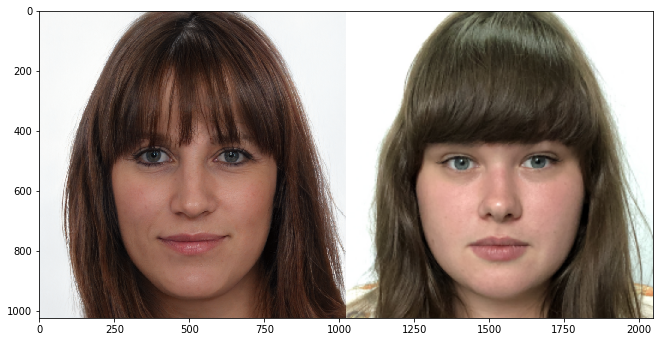

In [20]:
frame_rgb=imageio.imread('IMG_0399.JPG')
M, iM = get_image_align(frame_rgb, predictor=predictor, detector=detector)
image_to_predict = cv2.warpPerspective(frame_rgb, M, (512, 512),borderMode=cv2.BORDER_REPLICATE)
frame_data  = block_reduce(image_to_predict, (2,2,1),np.mean) 
pred_result0 = encoder_model0_5.predict(frame_data[None,...])
pred_result1 = encoder_model6_11.predict(frame_data[None,...])
pred_result2 = encoder_model12_17.predict(frame_data[None,...])
pred_result0 = pred_result0.reshape(-1,6,512)
pred_result1 = pred_result1.reshape(-1,6,512)
pred_result2 = pred_result2.reshape(-1,6,512)
pred_result = np.concatenate([pred_result0,pred_result1,pred_result2],axis=1)
result = Gs.components.synthesis.get_output_for(pred_result,randomize_noise=False)
plt.imshow(np.concatenate([np.transpose(K.eval(result)/2 + 0.5,(0,2,3,1))[0],cv2.resize(frame_data,(1024,1024))/255.],axis=1))
plt.show()


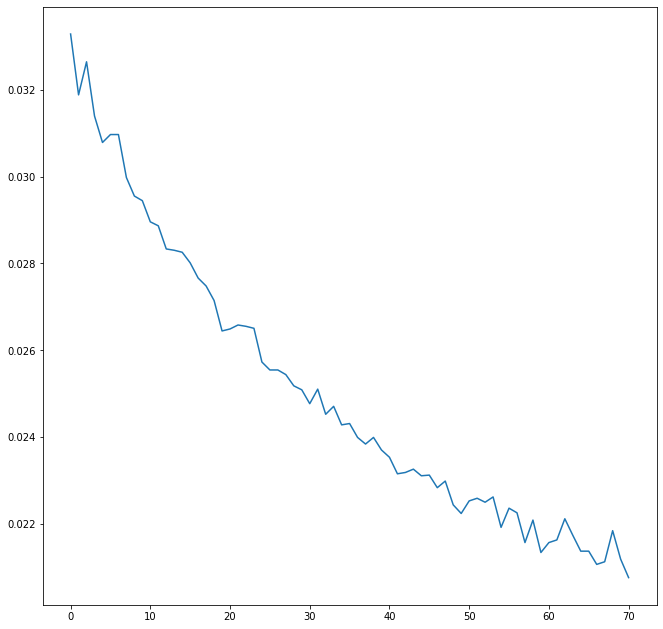

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


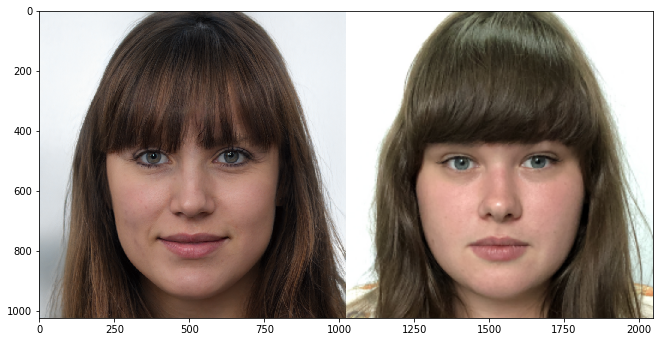

Epoch 4052/4052
512/512 [==============================] - 102s 200ms/step - loss: 0.0210
Epoch 4053/4053
512/512 [==============================] - 102s 200ms/step - loss: 0.0207
Epoch 4054/4054
512/512 [==============================] - 102s 200ms/step - loss: 0.0206
Epoch 4055/4055
512/512 [==============================] - 102s 200ms/step - loss: 0.0207
Epoch 4056/4056
512/512 [==============================] - 102s 200ms/step - loss: 0.0209
Epoch 4057/4057
512/512 [==============================] - 102s 200ms/step - loss: 0.0209
Epoch 4058/4058
 31/512 [>.............................] - ETA: 1:35 - loss: 0.0203

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[1,32,1025,1025] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node lambda_2/G_synthesis/1024x1024/Conv0_up/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Mean/_8195]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[1,32,1025,1025] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node lambda_2/G_synthesis/1024x1024/Conv0_up/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [21]:
#train_hst = []

batch_size=1
for e_item in range(800,10024):
        
    hst = train_model.fit_generator(get_generator(batch_size), initial_epoch=e_item, epochs=e_item+1, steps_per_epoch=512)    
    
    if e_item%50==0:
        clear_output()
        train_hst.extend(np.float16(hst.history['loss']))
        plt.plot(train_hst)
        plt.show()
        pred_result0 = encoder_model0_5.predict(frame_data[None,...])
        pred_result1 = encoder_model6_11.predict(frame_data[None,...])
        pred_result2 = encoder_model12_17.predict(frame_data[None,...])
        pred_result0 = pred_result0.reshape(-1,6,512)
        pred_result1 = pred_result1.reshape(-1,6,512)
        pred_result2 = pred_result2.reshape(-1,6,512)
        pred_result = np.concatenate([pred_result0,pred_result1,pred_result2],axis=1)
        result = Gs.components.synthesis.get_output_for(pred_result,randomize_noise=False)
        plt.imshow(np.concatenate([np.transpose(K.eval(result)/2 + 0.5,(0,2,3,1))[0],cv2.resize(frame_data,(1024,1024))/255.],axis=1))
        plt.show()

    encoder_model0_5.save_weights('networks/encoder_model_0_5_16.04.hdf5')
    encoder_model6_11.save_weights('networks/encoder_model_6_11_16.04.hdf5')
    encoder_model12_17.save_weights('networks/encoder_model1_2_17_16.04.hdf5')
    


In [22]:
encoder_model0_5.save_weights('networks/encoder_model_0_5_16.04.hdf5')
encoder_model6_11.save_weights('networks/encoder_model_6_11_16.04.hdf5')
encoder_model12_17.save_weights('networks/encoder_model1_2_17_16.04.hdf5')

In [7]:
from keras.layers import AveragePooling2D

In [8]:

in_layer = c_layer = Input((512,))
c_layer = d_latents_true = Lambda(lambda x: Gs.components.mapping.get_output_for(x, None, is_validation=True, randomize_noise=True), trainable=False)(c_layer)
c_layer = Lambda(lambda x: Gs.components.synthesis.get_output_for(x, is_validation=True, randomize_noise=True), trainable=False)(c_layer)

c_layer = Lambda(lambda x: tf.tanh(tf.cast(tf.transpose((x+1)/2, (0, 2, 3, 1)), tf.float32)), trainable=False)(c_layer)

#c_layer = Lambda(lambda x:tf.image.resize(x,(128,128)))(c_layer)
c_layer = AveragePooling2D(pool_size=(8, 8))(c_layer)

c_layer = Lambda(lambda x: tf.cast(255*x, tf.uint8))(c_layer)


new_model = Model(in_layer, [c_layer,d_latents_true])


In [9]:
from tqdm import tqdm


In [10]:
fp = np.memmap('/home/user/work/work/Projects/_data_set/local_files/image_stylegan2_new_128*1024х128х128х3.npy', dtype=np.uint8, mode='w+', shape=(256*1024,128, 128, 3))

fp2 = np.memmap('/home/user/work/work/Projects/_data_set/local_files/latents_stylegan2_new_128*1024х18х512.npy', dtype=np.uint8, mode='w+', shape=(256*1024,18, 512))



In [11]:
batch_size=1
for i in tqdm(range(256*1024)):
    src_latents = np.random.normal(size=(batch_size, Gs.input_shape[1]))
    pred_im, pred_lat = new_model.predict(src_latents)
    fp[i]=pred_im[0]
    fp2[i]=pred_lat[0]

100%|██████████| 262144/262144 [2:36:58<00:00, 27.83it/s]  


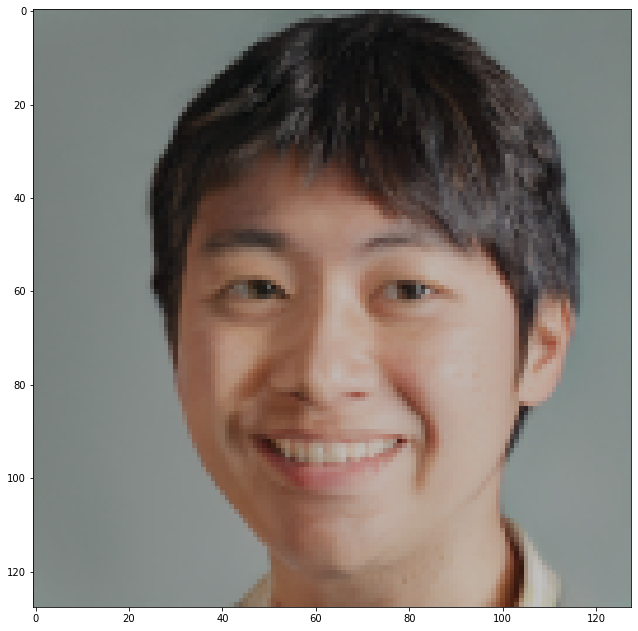

In [33]:
fp2 = np.memmap('image_stylegan2_128*1024х128х128х3.npy', dtype=np.uint8, mode='r+', shape=(128*1024,128, 128, 3))



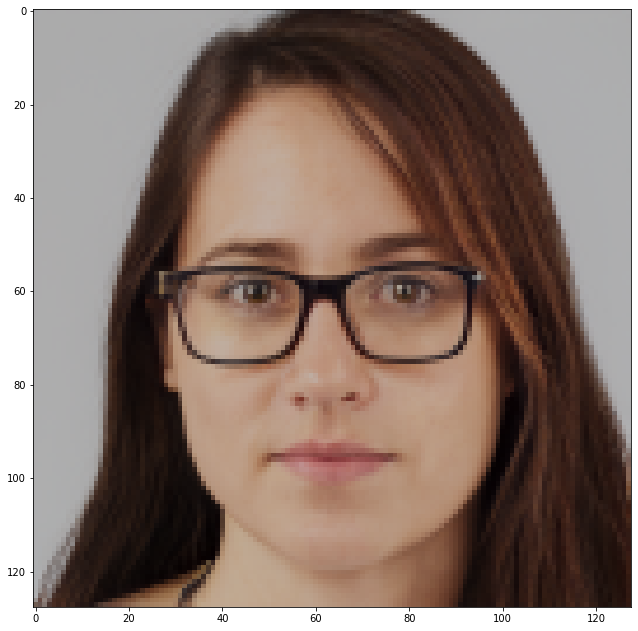

In [37]:
plt.imshow(fp2[204])

In [23]:
batch_size=1
src_latents = np.random.normal(size=(batch_size, Gs.input_shape[1]))
pred_im = new_model.predict(src_latents)
pred_im.shape

(1, 128, 128, 3)

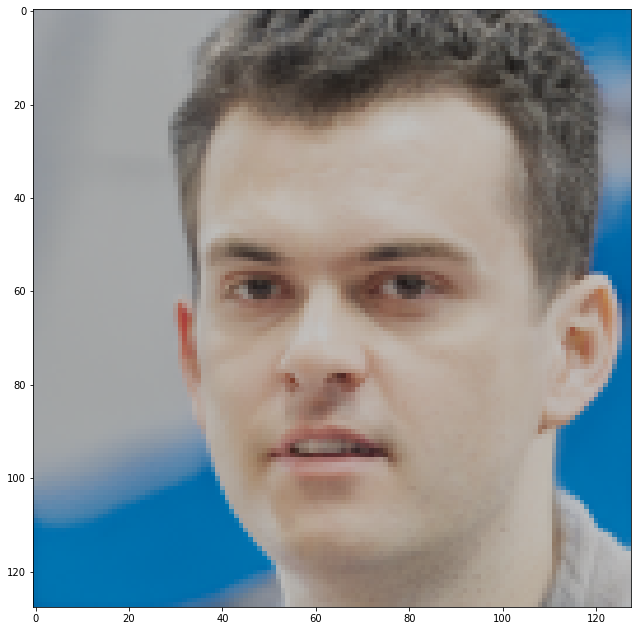

In [24]:
plt.imshow(pred_im[0])